## Выполнил Сенин Александр (aaasenin@gmail.com)

Время выполнения - три дня.

*28.10.21*

## Условие

Даны данные одного крупного онлайн магазина, перед которым стоит классическая задача продуктового мачинга. У магазина много поставщиков одинаковых товаров и все они называют их по разному, задача найти одни и те же товары с разными названиями и объединить их в группы.

Для каждого товара нужно выдать список товаров которые модель считает одинаковыми. При этом таких товаров не может быть более 50 для одной группы. Метрикой для задачи будет среднее построчного F1.

In [235]:
import numpy as np
import pandas as pd

In [236]:
df = pd.read_csv('train_data.csv')
df.shape

(20952, 3)

In [237]:
df.head()

,posting_id,title,label_group
0,train_129225211,Paper Bag Victoria Secret,249114794
1,train_2278313361,PAPER BAG VICTORIA SECRET,249114794
2,train_2288590299,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_3803689425,Maling Ham Pork Luncheon Meat TTS 397gr,2395904891
4,train_2406599165,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188


In [238]:
df.label_group.unique().shape

(6608,)

In [239]:
tmp = df.groupby(['label_group'])['posting_id'].unique().to_dict()
df['matches'] = df['label_group'].map(tmp)
df['matches'] = df['matches'].apply(lambda x: ' '.join(x))

Метрикой будет построчный f1.

In [240]:
def f1_score(y_true, y_pred):
    y_true = y_true.apply(lambda x: set(x.split()))
    y_pred = y_pred.apply(lambda x: set(x.split()))
    intersection = np.array([len(x[0] & x[1]) for x in zip(y_true, y_pred)])
    len_y_pred = y_pred.apply(lambda x: len(x)).values
    len_y_true = y_true.apply(lambda x: len(x)).values
    f1 = 2 * intersection / (len_y_pred + len_y_true)
    return f1

В качестве бейзлайна сопоставим себя в группу только с самим собой и каким-нибудь еще одним случайным товаром.

In [241]:
df['prediction'] = df['posting_id'] + ' ' + 'train_129225211'

In [242]:
y_true = df['matches']
y_pred = df['prediction']
y_true = y_true.apply(lambda x: set(x.split()))
y_pred = y_pred.apply(lambda x: set(x.split()))
intersection = np.array([len(x[0] & x[1]) for x in zip(y_true, y_pred)])

In [243]:
f1_score(df['matches'], df['prediction']).mean()

0.35675992543848534

Цель - улучшить эту метрику.

# Решение

***Imports***

In [244]:
#import sys
#!{sys.executable} -m pip install metric-learn
#!{sys.executable} -m pip install jellyfish
#!{sys.executable} -m pip install fuzzywuzzy
#!{sys.executable} -m pip install stopwords
#!{sys.executable} -m pip install pytorch_metric_learning
#!{sys.executable} -m pip install python_levenshtein
#!{sys.executable} -m pip install optuna

In [245]:
#from google.colab import drive
#drive.mount('/content/drive')
#path = '/content/drive/My Drive/train_data.csv'

In [246]:
import seaborn as sns
import matplotlib.pyplot as plt
import time
from tqdm import tqdm 
from itertools import combinations

import string
import re
import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from gensim.models import FastText, Word2Vec
import jellyfish as jf
from fuzzywuzzy import fuzz

from sklearn.metrics import f1_score as f1_sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

from scipy.spatial import distance_matrix
from scipy.sparse import csr_matrix

# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
import optuna
import functools

In [247]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader

In [248]:
from metric_learn import RCA
from pytorch_metric_learning import samplers, losses, reducers

In [249]:
import warnings
warnings.filterwarnings("ignore")

***Немного EDA***

В архиве помимо train_data.csv лежит test_data.csv, но там нет таргета (что логично). Поэтому, работаем только с train_data.csv, а для оценки качества поступаем так:
- В случае unsupervised методов оцениваемся на всей выборке
- В случае supervised методов откладываем валидационную выборку размера 0.2~0.3 от общей и оцениваемся на ней

In [250]:
df["posting_id"].unique().shape

(20952,)

Совпадает с размером датасета, значит posting_id - честный уникальный айди.

Смотрим на распределение длины таргета (колонки matches).

In [251]:
df["matches_len"] = df["matches"].apply(lambda x: len(x.split()))

<AxesSubplot:ylabel='Frequency'>

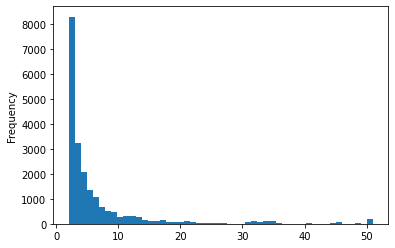

In [252]:
df["matches_len"].plot.hist(bins=50)

В 8к случаев таргет длины 2. Учитываем, что в таргете для каждого объекта уже есть айди этого же объекта. То есть в 8к случаев у объекта есть всего один сосед, которого нужно найти.

Из этих соображений понятно, почему значение F1 на бейзлайне - 0.35. В 8к случаев у нас уже есть половина ответа (в предсказание протекает айди самого объекта). Поэтому, возможно, лучше было бы считать F1 на ответах без айди самого объекта.

Еще заметим, что у большей половины объектов длина таргета не превосходит 6.

Посмотрим на самый большой (и самый редкий) кластер (множество объектов с одинаковым таргетом, причем длина этого таргета максимальна в данном случае).

In [253]:
df[df["matches_len"] == 26].head(4)

,posting_id,title,label_group,matches,prediction,matches_len
1066,train_2648609819,Bee123 Kain lap kanebo,821583868,train_2648609819 train_3784133722 train_236576...,train_2648609819 train_129225211,26
1067,train_3784133722,KANEBO SERAT SERAP AIR / LAP KAIN KANEBO MURAH...,821583868,train_2648609819 train_3784133722 train_236576...,train_3784133722 train_129225211,26
1068,train_2365762721,KANEBO SERAT SUPER TEBAL HALUS,821583868,train_2648609819 train_3784133722 train_236576...,train_2365762721 train_129225211,26
1069,train_3276258443,Kanebo Refil Polos Sedang - Grosir - AION Plas...,821583868,train_2648609819 train_3784133722 train_236576...,train_3276258443 train_129225211,26


Во всех названиях есть слово "kanebo". Посмотрим на объекты с таргетом длины 2.

In [254]:
df[df["matches_len"] == 2].head(6)

,posting_id,title,label_group,matches,prediction,matches_len
0,train_129225211,Paper Bag Victoria Secret,249114794,train_129225211 train_2278313361,train_129225211 train_129225211,2
1,train_2278313361,PAPER BAG VICTORIA SECRET,249114794,train_129225211 train_2278313361,train_2278313361 train_129225211,2
2,train_2288590299,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,train_2288590299 train_3803689425,train_2288590299 train_129225211,2
3,train_3803689425,Maling Ham Pork Luncheon Meat TTS 397gr,2395904891,train_2288590299 train_3803689425,train_3803689425 train_129225211,2
4,train_2406599165,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,train_2406599165 train_3342059966,train_2406599165 train_129225211,2
5,train_3342059966,DASTER PIYAMA KATUN JEPANG(TIDAK BISA PILIH MO...,4093212188,train_2406599165 train_3342059966,train_3342059966 train_129225211,2


Здесь аналогично, есть небольшие пересечения некоторых уникальных слов.

### Простое ML решение

Возникает первая плодотворная идея. Хотим обращать внимание на пересечение редких слов - тут подойдет tf-idf, особенно важен множитель idf - он и даст степень редкости. 

In [255]:
df["pure_matches"] = (df["matches"].apply(lambda x: set(x.split())) - \
                      df["posting_id"].apply(lambda x: set([x]))).apply(lambda x: ''.join(x))

In [256]:
tfidf = TfidfVectorizer(stop_words="english")
X = tfidf.fit_transform(df['title'])
y = df["label_group"]

Построим для каждого объекта tf-idf представление. Воспользуемся тем, что в длина таргета 2 - очень популярна. Будем предсказывать одного ближайшего соседа в пространстве tf-idf (если в двух заголовках одного и того же товара есть общие уникальные слова, то их tf-idf представления будут похожи).

In [257]:
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

In [259]:
df["knn_pred"] = ""
for i, val in enumerate(indices):
    df["knn_pred"].iloc[i] = f"{df['posting_id'].iloc[val[0]]} {df['posting_id'].iloc[val[1]]}"

In [260]:
f1_score(df['matches'], df['knn_pred']).mean()

0.6081975535382363

**Качество выросло в 2 раза - 0.61**. Ключевой недостаток - предсказываем ответ фиксированной длины 2, а он, вообще говоря, произволен. Если это исправить, потенциально можно получить качество больше.

Можно даже посчитать метрику (качество) на объектах, для которых таргет действительно длины 2.

In [261]:
base_df = df[df["matches_len"] == 2]

In [262]:
tfidf = TfidfVectorizer(stop_words="english")
X = tfidf.fit_transform(base_df['title'])
y = base_df["label_group"]

In [263]:
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

In [264]:
base_df["knn_pred"] = ""
for i, val in enumerate(indices):
    base_df["knn_pred"].iloc[i] = f"{base_df['posting_id'].iloc[val[0]]} {base_df['posting_id'].iloc[val[1]]}"

In [265]:
f1_score(base_df['matches'], base_df['knn_pred']).mean()

0.8616534104603519

**Только на таргетах длины 2 - качество 0.86**. Действительно, метрика сильно проседает из-за предположения о фиксированной длине таргета. Это хороший знак - задача хорошо ложится под построение эмбеддингов и нахождение кластеров каким-нибудь расстоянием. Даже в случае, когда в качестве эмбеддингов используется tf-idf представление вместе с евклидовым расстоянием (которое, вообще говоря, не обязано хорошо работать на сильно разреженных векторах tf-idf огромной размерности) - уже получается неплохое качество. 

Важное замечание: kNN (1NN) никак не использовал таргет, только tf-idf представления, то есть это чистое unsupervised решение.

Введем метки кластеров (на самом деле они уже были в оригинальном датасете, поэтому просто нумеруем заново).

In [266]:
del df["label_group"]

matches_to_labels = {}
label = 0
matches_tupled = df["matches"].apply(lambda x: tuple(sorted(x.split())))
for key in matches_tupled.values:
    if key not in matches_to_labels:
        matches_to_labels[key] = label
        label += 1
        
df["label"] = matches_tupled.apply(lambda x: matches_to_labels[x])

***Text preprocessing***

Попробуем более сложное решение. Работаем с текстами - нужен препроцессинг. Удаляем пунктуацию, стопслова, приводим к одному регистру, лемматизируем и токенизируем.

In [39]:
extended_punctuation = """'!"#$%&\'()*,-/:;®™<=>?@[\\]^_`{|}~+"""

def remove_punct(s):
    return "".join([char for char in s if char not in extended_punctuation])

def lower(s):
    return s.lower()

def reduce_spaces(s):
    return re.sub(' +', ' ', s)

def tokenize(s):
    s = s.replace(".", " ")
    return s.split()

def filter_stop_words(tokens):
    stop_words = stopwords.get_stopwords("english")
    return [token for token in tokens if token not in stop_words]

def stem(tokens):
    stemmer = PorterStemmer()
    return [stemmer.stem(token) for token in tokens]
   
def lemmatize(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

def preproc(s):
    clean_s = reduce_spaces(remove_punct(lower(s)))
    tokens = lemmatize(filter_stop_words(tokenize(clean_s)))
    return np.array(tokens)

In [41]:
#import nltk
#nltk.download('wordnet')

df['text'] = df['title'].apply(lambda x: preproc(x))

### DL решение

Опишем мотивацию выбора архитектуры.

Хотим применить нейронки. Пусть с помощью нейронки для каждого объекта (суть заголовка товара) можем получить эмбеддинг. Тогда в пространстве эмбеддингов сможем найти кластеры объектов. Это могут быть как кластеры размера 2 (пары объектов, та же идея с 1NN), это могут быть и кластеры произвольного размера. В теории по эмбеддингам можем посчитать расстояния на парах объектов, а затем по некоторому порогу определять соседей. Другими словами, для каждого объекта будем относить в один с ним кластер все объекты в шаре (в случае евклидовой метрики) некоторого радиуса (который и определяется порогом) с центром в эмбеддинге этого объекта. Подход с кластером размера 2 будем называть 1NN, подход с варьированием порога - adaptive neighbors (адаптивный в смысле перебора порога).

Осталось обучить нейронку строить эмбеддинги...

Смотрим на число слов в датасете.

In [42]:
def vocab(series):
    return {
        token
        for tokens in series.values
            for token in tokens
    }

In [43]:
len(vocab(df['text']))

19987

Почти 20к, причем в валидационной (тестовой) выборке могут оказаться незнакомые слова. Более того, среди этих 20к слов много уникальных (крайне редко встречающихся). Например, название каких-нибудь уникальных наушников (которое встретится в худшем случае всего 2 раза в выборке) Sony в духе "Sony Wireless Z Ultra C6833 HX-mk2" породит слова "C6833" и "HX-mk2".

В этих условиях, строить эмбеддинг заголовка на базе его слов проблематично. За единицу отсчета возьмем символы. Посимвольные RNN-ки тоже неплохо работают, и даже умеют генерить полуосмысленный текст, если обучать их предсказывать следующий символ.

Следующая проблема - заголовки у нас последовательности произвольной длины. Возьмем идею энкодера из seq2seq. В классике энкодер представляет собой RNN-блок, который, получив последовательность слов или символов, возвращает некоторый сжатый вектор, который уже декодируется декодером.

Длины последовательностей символов заголовков могут быть приличные, а RNN имеет свойство забывать. Поэтому будем использовать LSTM блок.

Будем считать, что энкодер закодирует нам эмбеддинг, далее нужно подсказать сети, какие эмбеддинги соответствуют одному товару, а какие разным. Здесь подойдет metric learning. Используем логику работы сиамских сетей и старый-добрый triplet loss (contrasitive loss показал себя хуже).

Резюмируем:
- *На этапе обучения* разбиваем заголовок на последовательность символов, каждый символ подаем на вход LSTM блоку, скрытое состояние перекидываем следующему блоку, так до тех пор, пока последовательность не закончится. Получаем вектор скрытого состояния, к которому относимся как к эмбеддингу, полученному энкодером. Аналогично получаем эмбеддинги anchor-positive и anchor-negative объектов. Аггрегируем эти эмбеддинги с помощью triplet loss, заставляем их расстояния отличаться на величину отступа (margin). После, кстати, будет логично использовать значение близкое к отступу в качестве порога в адаптивном поиске кластеров.
- *На этапе контроля* получаем эмбеддинги обученным энкодером, а затем ищем в пространстве эмбеддингов соседа (1NN) или соседей по порогу (adaptive).

***Tokens encoding***

Сохраняем биекцию символов в числовые коды (LSTM блок на вход принимает числа), переводим весь наш корпус в эти коды.

In [44]:
def build_corpus_per_word(text_series):
    corpus = [
        tokens.tolist()
        for series in text_series
            for tokens in series.values
    ]
    return corpus

def build_corpus_per_char(text_series):
    corpus = [
        list("_".join(tokens.tolist()))
        for series in text_series
            for tokens in series.values
    ]
    return corpus

In [45]:
class Corpus:
    def __init__(self, default_tokens):
        self.token2idx = default_tokens
        self.token2count = {token: 1 for token in default_tokens}
        self.idx2token = {default_tokens[token]: token for token in default_tokens}
        self.n_words = len(default_tokens)
    
    def fit(self, corpus):
        self.corpus = corpus
        for tokens in corpus:
            for token in tokens:
                if token in self.token2idx:
                    self.token2count[token] += 1
                else:
                    self.token2idx[token] = self.n_words
                    self.token2count[token] = 1
                    self.idx2token[self.n_words] = token
                    self.n_words += 1

In [ ]:
def transform_chars(batch, corpus):
    return [
        [corpus.token2idx[char] for char in list("_".join(tokens.tolist()))]
        for tokens in batch
    ]

***Padding & packing***

Обучать сеть хотим по батчам. Это и эффективно по времени, и уменьшает смещение стохастического градиента. Здесь следующая трудность: батч состоит из последовательностей кодов символов, но эти последовательности будут разной длины. Решаем проблему забиванием нулями с конца всех последовательностей так, чтобы их длина совпадала с максимальной в батче. 

Проблема переменных длин в батче аукнется и при генерации батчей даталоадером. В этом случае нужна функция collate.

In [ ]:
def preproc_vect_seq_batch(batch2idx):
    # finding max seq len
    seq_lens = torch.LongTensor(list(map(len, batch2idx)))
    seq_tensor = Variable(torch.zeros((len(batch2idx), seq_lens.max()))).long()
    
    # filling seqs, padding with zeros
    for idx, (seq, seq_len) in enumerate(zip(batch2idx, seq_lens)):
        seq_tensor[idx, :seq_len] = torch.LongTensor(seq)
        
    # pushing seqs with max zeros amount to the end
    seq_lens, perm_idx = seq_lens.sort(0, descending=True)
    seq_tensor = seq_tensor[perm_idx]
    
    return seq_tensor, seq_lens, perm_idx

def collate_pad(batch):
    batch2idx = [obj[0] for obj in batch]
    labels = [obj[1] for obj in batch]
    seq_tensor, seq_lens, perm_idx = preproc_vect_seq_batch(batch2idx)
    
    return seq_tensor.to(DEVICE), seq_lens.to(DEVICE), torch.tensor(labels)[perm_idx].to(DEVICE)

***Model***

Непосредственно энкодер.

In [ ]:
# padding idea from https://gist.github.com/HarshTrivedi/f4e7293e941b17d19058f6fb90ab0fec

class Encoder(nn.Module):
    # N - batch size; L - seq len; H - hidden size; E - embed_size
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(Encoder, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(vocab_size, embed_size) # num_embeddings, embedding_dim
        self.rnn = nn.LSTM(embed_size, hidden_size, batch_first=True)
        
    def forward(self, batch):
        seq_tensor, seq_lens, _ = batch # (N, L); (N, )
        embeds = self.embedding(seq_tensor) # (N, L, E)
        
        packed_input = pack_padded_sequence( # (batch_sum_seq_len, E)
            embeds, seq_lens.cpu(), batch_first=True
        ) 
        
        _, (hidden, cell) = self.rnn(packed_input) # cell for LSTM
        
        return hidden[-1] # (N, H)

Аналоги построчного усреднения F1 для предсказаний сети.

In [ ]:
def f1_score_labels_1d(y_true, y_pred):
    intersection = set(y_true) & set(y_pred)
    return 2 * len(intersection) / (len(y_true) + len(y_pred))

def f1_score_labels(y_true, y_pred):
    out = []
    for i, label in enumerate(y_true):
        true_idxs = np.where(y_true == label)[0]
        pred_idxs = y_pred[i]
        out.append(f1_score_labels_1d(true_idxs, pred_idxs))
    return np.mean(np.array(out))

Конечное предсказание кластеров - 1NN и перебор порога, а также валидация и обучение. Оцениваемся усредненным построчным F1 на отложенной выборке.

In [ ]:
def predict_1neighbor(X, dists):
    # rows of X - coords
    # dists - pairwise distances
    # returns idx of closest neighbor for every object
    dists[np.arange(len(dists)), np.arange(len(dists))] = np.max(dists)
    
    pred = np.argmin(dists, axis=0)
    return np.vstack((np.arange(len(X)), pred)).T

def predict_neighbors_adaptive(X, dists, thresh):
    # rows of X - coords
    # returns idxs of neighbors wrt to threshold for every object
    dists[np.arange(len(dists)), np.arange(len(dists))] = np.max(dists)

    output = [[i] for i in range(len(X))]
    wheres = np.where(dists < thresh)
    for i in range(len(wheres[0])):
        idx, value = wheres[0][i], wheres[1][i]
        if len(output[idx]) < 52: # no more than 51 neighbors in real data
            output[idx].append(value)
    
    return output

In [ ]:
def validate_model(model, test_loader, X_val_len, y_val, output_label="VAL"):
        
    pred_val = torch.zeros((X_val_len, HIDDEN_SIZE))
    with torch.no_grad():
        for data in test_loader:
            _, _, seq_idxs = data
            hidden = model(data)
            for i, pred_val_i in enumerate(seq_idxs):
                pred_val[pred_val_i] = hidden[i]
    
    X = pred_val.detach().numpy()
    start = time.time()
    dists = distance_matrix(X, X)
    y_pred_1nn = predict_1neighbor(X, dists)
    f1_1nn = f1_score_labels(y_val, y_pred_1nn)

    f1_adapt_list = []
    for thresh in THRESH:
        y_pred_adapt = predict_neighbors_adaptive(X, dists, thresh)
        f1_adapt = f1_score_labels(y_val, y_pred_adapt)
        f1_adapt_list.append(f1_adapt)
        
    print(f"{output_label} | 1NN F1: {round(f1_1nn, 4)}")
    print(f"{output_label} | ADAPT", end="")
    for i in range(len(THRESH)):
        print(f"|TH: {THRESH[i]} F1: {round(f1_adapt_list[i], 4)}", end="")
    print('')
    
    return f1_1nn, f1_adapt_list

In [ ]:
def train_epoch(model, optimizer, loss_func, train_loader, test_loader, 
                X_train_len, X_val_len, y_train, y_val, flush_rate=100):
    val_output = []
    running_loss = 0
    batch_losses = []
    avg_losses = []
    epoch_start = time.time()
    for i, data in enumerate(train_loader):
        # data - (seq, seq_len, label)
        optimizer.zero_grad()
        embeddings = model(data)
        labels = data[-1]
        loss = loss_func(embeddings, labels)
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())
        running_loss += loss.item() * data[0].shape[0]
        
        if (i + 1) % flush_rate == 0:
            avg_loss = np.array(batch_losses).mean()
            avg_losses.append(avg_loss)
            print(f"ITER {i + 1} | AVERAGE LOSS {round(avg_loss, 3)} | RUNNING LOSS {round(running_loss, 3)}")
            val_output.append(validate_model(model, test_loader, X_val_len, y_val, "TEST"))
            batch_losses = []
    running_loss /= len(train_loader)
    
    print(f"EPOCH OVER ({round(time.time() - epoch_start, 2)} sec) | AVG LOSS {round(np.array(batch_losses).mean(), 3)} | RAN LOSS {round(running_loss, 3)}")
    validate_model(model, test_loader, X_val_len, y_val, "TEST")
    
    return val_output, avg_losses, running_loss

***Training***

Строим корпус, переводим в коды, разбиваем на обучение и контроль.

In [ ]:
corpus = Corpus({"PAD": 0, "_": 1})
corpus.fit(build_corpus_per_char([df['text']]))

X = transform_chars(df['text'].values, corpus)
y = df['label'].values

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=1337
)

Xy_train = list(zip(X_train, y_train))
Xidx_val = list(zip(X_val, [i for i in range(len(X_val))]))

Используем полезные функции из библиотеки pytorch-metric-learning, это
- сэмплер - строит батч таким образом, что в нем обязательно есть хотя бы два заголовка одного товара (не должен встретиться объект, для которого не будет anchor-positive)
- волшебный triplet loss, который самостоятельно перебирает все подходящие тройки в батче

Размерность эмбеддингов (они же скрытые состояния у LSTM) выберем заведомо небольшой, чтобы избежать проклятия размерности.
Оптимизируем адамом, без регуляризации. Тюнинг гиперпараметров в данном ноутбуке удалим, и так много получается.

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EMBED_SIZE = 64
HIDDEN_SIZE = 64
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0
THRESH = [0.01, 0.05, 0.1, 0.15, 0.2]

sampler = samplers.MPerClassSampler(labels=y_train, m=2, batch_size=BATCH_SIZE, length_before_new_iter=100000)
# reducer = reducers.MeanReducer()
train_loader = DataLoader(dataset=Xy_train, sampler=sampler, batch_size=BATCH_SIZE, collate_fn=collate_pad)
test_loader = DataLoader(dataset=Xidx_val, batch_size=BATCH_SIZE, collate_fn=collate_pad)
model = Encoder(
    vocab_size=corpus.n_words,
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE
).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_func = losses.TripletMarginLoss(margin=0.1,
                        swap=False,
                        smooth_loss=False,
                        triplets_per_anchor="all")
#loss_func = losses.ContrastiveLoss(pos_margin=0, neg_margin=, reducer=reducer) # eucl dist by default

In [ ]:
NUM_EPOCHS = 10

output = {}
for epoch in range(NUM_EPOCHS):
    print(f"EPOCH {epoch} START")
    out = train_epoch(
        model=model,
        optimizer=optimizer,
        loss_func=loss_func,
        train_loader=train_loader,
        test_loader=test_loader,
        X_train_len=len(X_train),
        X_val_len=len(X_val),
        y_train=y_train,
        y_val=y_val ,
        flush_rate=1000
    )   
    output[epoch] = out

EPOCH 0 START
ITER 1000 | AVERAGE LOSS 0.123 | RUNNING LOSS 3949.582
TEST | 1NN F1: 0.5541
TEST | ADAPT|TH: 0.01 F1: 0.189|TH: 0.05 F1: 0.0994|TH: 0.1 F1: 0.0805|TH: 0.15 F1: 0.0735|TH: 0.2 F1: 0.0696
ITER 2000 | AVERAGE LOSS 0.11 | RUNNING LOSS 7477.237
TEST | 1NN F1: 0.555
TEST | ADAPT|TH: 0.01 F1: 0.5579|TH: 0.05 F1: 0.1451|TH: 0.1 F1: 0.0884|TH: 0.15 F1: 0.0749|TH: 0.2 F1: 0.0681
ITER 3000 | AVERAGE LOSS 0.105 | RUNNING LOSS 10851.002
TEST | 1NN F1: 0.5552
TEST | ADAPT|TH: 0.01 F1: 0.6134|TH: 0.05 F1: 0.1673|TH: 0.1 F1: 0.096|TH: 0.15 F1: 0.0775|TH: 0.2 F1: 0.0703
EPOCH OVER (134.73 sec) | AVG LOSS 0.102 | RAN LOSS 3.603
TEST | 1NN F1: 0.5568
TEST | ADAPT|TH: 0.01 F1: 0.6975|TH: 0.05 F1: 0.2098|TH: 0.1 F1: 0.1035|TH: 0.15 F1: 0.0792|TH: 0.2 F1: 0.0702
EPOCH 1 START
ITER 1000 | AVERAGE LOSS 0.103 | RUNNING LOSS 3306.878
TEST | 1NN F1: 0.5569
TEST | ADAPT|TH: 0.01 F1: 0.7493|TH: 0.05 F1: 0.2878|TH: 0.1 F1: 0.128|TH: 0.15 F1: 0.0912|TH: 0.2 F1: 0.0749
ITER 2000 | AVERAGE LOSS 0.102 | 

**Качество 1NN на контроле ~0.58** после 10 эпох (близко к 1NN на tf-idf).

**Качество adaptive neighbors ~0.79**.

Смотрим динамику лосса и качества F1 с течением эпох.

Text(0, 0.5, 'loss')

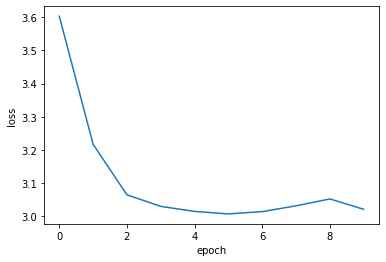

In [ ]:
sns.lineplot(x=list(output.keys()), y=[output[epoch][-1] for epoch in output])
plt.xlabel("epoch")
plt.ylabel("loss")

Text(0, 0.5, 'F1')

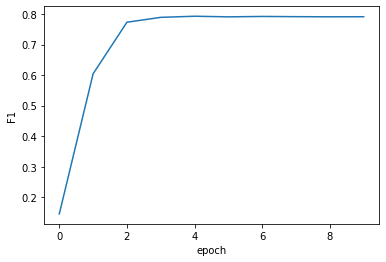

In [ ]:
sns.lineplot(x=list(output.keys()), y=[output[epoch][0][1][-1][1] for epoch in output])
plt.xlabel("epoch")
plt.ylabel("F1")

### ML решение

Еще во время препроцессинга текстов заголовков и построения корпуса автор обратил внимание на очень хорошее пересечение токенов заголовков одного товара. Возникла идея пропустить этап построения эмбеддингов, а перейти сразу к подсчету расстояния. Причем в простейшем случае использовать примитивное пересечение множеств токенов.

Строим множества токенов, считаем попарные пересечения (используем разреженные матрицы), варьируем порог и смотрим на качество.

In [42]:
setted_series = df["text"].apply(lambda x: set(x))
pairwise_inters = [setted_series.apply(lambda x: len(x & row)).to_numpy() for row in setted_series]

X = np.array(pairwise_inters)
sparse_X = csr_matrix(X)

In [44]:
for thresh in range(2, 6):
    rows, cols = (sparse_X > thresh).nonzero()
    df["inter_pred"] = ""
    for i, j in tqdm(list(zip(rows, cols))):
        df["inter_pred"][i] += " " + df["posting_id"][j]
    df["inter_pred"].apply(lambda string: string[1:])
    print(f"THRESH: {thresh}, F1: {f1_score(df['matches'], df['inter_pred']).mean()}")

100%|██████████| 529700/529700 [02:49<00:00, 3133.52it/s]


THRESH: 2, F1: 0.47134041740652705


100%|██████████| 215777/215777 [01:06<00:00, 3227.24it/s]


THRESH: 3, F1: 0.5606379513777408


100%|██████████| 114704/114704 [00:34<00:00, 3347.95it/s]


THRESH: 4, F1: 0.5390206265571864


100%|██████████| 69504/69504 [00:20<00:00, 3428.98it/s]


THRESH: 5, F1: 0.4622199113068653


**Качество 0.56**.

***Classification problem***

Хотим использовать машинное обучение вместо ручного подбора порога. Переформулируем исходную задачу. Пусть объект - не заголовок, как раньше, а пара заголовков. Целевая переменная - отвечают ли заголовки в паре одному товару. Имеем бинарный таргет и бинарную задачу классификации.

Решейпим датафрейм в обучающую выборку под задачу классификации. 1 классом считаем заголовки одного товара, 0 классом - разных. Очевидно, как получить все объекты 1 класса по исходной выборке. Для получения объектов 0 класса можем использовать случайные пары заголовков разных товаров. 

По исходной выборке строим подвыборку объектов 1 класса. 

In [46]:
aggregated = df.groupby("label")["text"].agg(lambda x: list(combinations(x, 2))).explode()

pair_df = pd.DataFrame(
    aggregated.to_list(),
    columns=["title1", "title2"]
)

pair_df["target"] = aggregated.index
pair_df["class"] = 1

positive_class_size = len(aggregated)
print(f"Всего пар 1 класса {positive_class_size}")

Всего пар 1 класса 55654


Случайность для построения объектов 0 класса будем моделировать сдвигом. В подвыборке объектов 1 класса получены два столбца, отвечающие заголовкам. Сдвинем один столбец вверх, а второй вниз так, что на пересечении строк окажутся заголовки разных товаров. 

Берем сдвиг в 2000, проверяем что все товары действительно разные (таргет не совпадает).

In [47]:
(pair_df[:-2000]["target"].to_numpy() == pair_df[2000:]["target"].to_numpy()).sum()

0

In [48]:
neg_df = pd.DataFrame(pair_df["title1"][2000:].reset_index(drop=True))
neg_df["title2"] = pair_df["title1"][:-2000].reset_index(drop=True)
neg_df["class"] = 0
pair_df = pair_df.drop("target", axis=1)
pair_df = pd.concat([pair_df, neg_df])

Итоговая новая обучающая выборка под задачу классификации (110к объектов против исходных 20к). Важное замечание: классы заведомо построены сбалансированно, примерно поровну с погрешностью в 4к сдвинутых заголовков.

In [49]:
pair_df

,title1,title2,class
0,"[paper, bag, victoria, secret]","[paper, bag, victoria, secret]",1
1,"[maling, tt, canned, pork, luncheon, meat, 397...","[maling, ham, pork, luncheon, meat, tt, 397gr]",1
2,"[daster, batik, lengan, pendek, motif, acak, c...","[daster, piyama, katun, jepangtidak, bisa, pil...",1
3,"[kulot, plisket, salur, candy, plisket, wish, ...","[kulot, plisket, momblu]",1
4,"[logu, tempelan, kulkas, magnet, angka, tempel...","[10pcs, magnet, kulkas, model, angka, 09, baha...",1
...,...,...,...
53649,"[fygalery, j189, jam, tangan, transparan, mere...","[gamis, murah, gamis, hyget]",0
53650,"[flex, tape, isolasi, ajaib, super, kuat, rubb...","[restock, jilbabhijab, segi, tiga, instan, haw...",0
53651,"[tempered, glass, samsung, galaxy, a30, a50, a...","[mouse, pad, gaming, hunter, original, asli]",0
53652,"[lampu, huruf, az, dan, angka, 09, xe2x9dxa4xe...","[st, ives, glowing, apricot, sheet, mask, mask...",0


***Feature Engineering***

Пойдем дальше в рассчете расстояний на заголовках. Заголовки - суть обычные строки из предобработанных токенов. Известно расстояние Левенштейна на строках (число перестановок). Используем некоторые его обобщения, а также другие строковые расстояния из библиотеки jellyfish.

In [50]:
pair_df["title1_str"] = pair_df["title1"].apply(lambda x: " ".join(x))
pair_df["title2_str"] = pair_df["title2"].apply(lambda x: " ".join(x))

In [51]:
pair_df["title1_str"] = pair_df["title1"].apply(lambda x: " ".join(x))
pair_df["title2_str"] = pair_df["title2"].apply(lambda x: " ".join(x))
pair_df["numbers1"] = pair_df["title1_str"].apply(lambda x: set(re.findall(r'[0-9]+', x)))
pair_df["numbers2"] = pair_df["title2_str"].apply(lambda x: set(re.findall(r'[0-9]+', x)))

s = time.time()

pair_df["levenshtein_distance"] = pair_df.apply(
    lambda x: jf.levenshtein_distance(x["title1_str"], x["title2_str"]), axis=1)

pair_df["damerau_levenshtein_distance"] = pair_df.apply(
    lambda x: jf.damerau_levenshtein_distance(x["title1_str"], x["title2_str"]), axis=1)

pair_df["hamming_distance"] = pair_df.apply(
    lambda x: jf.hamming_distance(x["title1_str"], x["title2_str"]), axis=1)

pair_df["jaro_similarity"] = pair_df.apply(
    lambda x: jf.jaro_similarity(x["title1_str"], x["title2_str"]), axis=1)

pair_df["jaro_winkler_similarity"] = pair_df.apply(
    lambda x: jf.jaro_winkler_similarity(x["title1_str"], x["title2_str"]), axis=1)

pair_df["match_rating_comparison"] = pair_df.apply(
    lambda x: jf.match_rating_comparison(x["title1_str"], x["title2_str"]), axis=1).fillna(False).astype(int)

print(f"JF ENGINEERING OVER ({round(time.time() - s, 2)} sec)")

JF ENGINEERING OVER (9.6 sec)


Используем расстояния на строках из библиотеки FuzzyWuzzy - расстояния, учитывающие порядок, повторения, вхождение одной строки в другую. 

In [52]:
s = time.time()

pair_df["ratio"] = pair_df.apply(
    lambda x: fuzz.ratio(x["title1_str"], x["title2_str"]), axis=1)

pair_df["token_sort_ratio"] = pair_df.apply(
    lambda x: fuzz.token_sort_ratio(x["title1_str"], x["title2_str"]), axis=1)

pair_df["token_set_ratio"] = pair_df.apply(
    lambda x: fuzz.token_set_ratio(x["title1_str"], x["title2_str"]), axis=1)

pair_df["partial_ratio"] = pair_df.apply(
    lambda x: fuzz.partial_ratio(x["title1_str"], x["title2_str"]), axis=1)

pair_df["WRatio"] = pair_df.apply(
    lambda x: fuzz.WRatio(x["title1_str"], x["title2_str"]), axis=1)

pair_df["UQRatio"] = pair_df.apply(
    lambda x: fuzz.UQRatio(x["title1_str"], x["title2_str"]), axis=1)

pair_df["QRatio"] = pair_df.apply(
    lambda x: fuzz.QRatio(x["title1_str"], x["title2_str"]), axis=1)

print(f"FUZZ ENGINEERING OVER ({round(time.time() - s, 2)} sec)")

FUZZ ENGINEERING OVER (436.63 sec)


Не забудем и про идею с которой все начиналось - считаем мощность пересечения, и связанное с ним (нормировкой) расстояние Жаккарда. Еще одна плодотворная идея - учитывать только числовые значения (в заголовках товаров много неймингов моделей с числами, в духе "PS5", "GTX3080" и т.д.). Аналогично считаем пересечения и Жаккарда только на числах. Дополнительно добавим признаки длин каждого заголовка и суммы длин, то же для чисел.

In [53]:
s = time.time()

pair_df["intersection"] = pair_df.apply(
    lambda x: len(set(x["title1"]) & set(x["title2"])), axis=1)

pair_df["jaccard"] = pair_df.apply(
    lambda x: len(set(x["title1"]) & set(x["title2"])) / len(set(x["title1"]) | set(x["title2"])), axis=1)

pair_df["len1"] = pair_df.apply(
    lambda x: len(x["title1"]), axis=1)

pair_df["len2"] = pair_df.apply(
    lambda x: len(x["title2"]), axis=1)

pair_df["lens"] = pair_df.apply(
    lambda x: len(x["title1"]) + len(x["title2"]), axis=1)

pair_df["numbers_intersection"] = pair_df.apply(
    lambda x: len(set(x["numbers1"]) & set(x["numbers2"])), axis=1)

pair_df["numbers_union"] = pair_df.apply(
    lambda x: len(set(x["numbers1"]) | set(x["numbers2"])), axis=1)

pair_df["numbers_jaccard"] = (pair_df["numbers_intersection"] / pair_df["numbers_union"]).fillna(0)

pair_df["len_numbers1"] = pair_df["numbers1"].apply(lambda x: len(x))

pair_df["len_numbers2"] = pair_df["numbers1"].apply(lambda x: len(x))

print(f"NUMBERS ENGINEERING OVER ({round(time.time() - s, 2)} sec)")

NUMBERS ENGINEERING OVER (10.74 sec)


***Training***

Будем решать задачу классификации градиентным бустингом XGBoost, гиперпараметры тюним с помощью optuna (некоторая рутина тюнинга опущена в финальном ноутбуке).

In [131]:
features = ['levenshtein_distance', 'damerau_levenshtein_distance',
       'hamming_distance', 'jaro_similarity', 'jaro_winkler_similarity',
       'match_rating_comparison', 'ratio', 'token_sort_ratio',
       'token_set_ratio', 'partial_ratio', 'WRatio', 'UQRatio', 'QRatio',
       'intersection', 'jaccard', 'len1', 'len2', 'lens',
       'numbers_intersection', 'numbers_union', 'numbers_jaccard',
       'len_numbers1', 'len_numbers2']

X = pair_df[features].values
y = pair_df["class"].values

X_train_pd, X_val_pd, y_train_pd, y_val_pd = train_test_split(
    pair_df,
    pair_df["class"],
    test_size=0.3,
    random_state=1337,
    stratify=y
)

X_train, X_val = X_train_pd[features].values, X_val_pd[features].values
y_train, y_val = y_train_pd.values, y_val_pd.values

In [113]:
def opt(X_train, y_train, X_test, y_test, trial):
    # based on https://www.kaggle.com/snakayama/xgboost-using-optuna
    n_estimators = trial.suggest_int('n_estimators', 600, 800)
    max_depth = trial.suggest_int('max_depth', 18, 30)
    learning_rate = trial.suggest_discrete_uniform('learning_rate', 0.03, 0.1, 0.05)
    scale_pos_weight = trial.suggest_int('scale_pos_weight', 4, 6)
    subsample = trial.suggest_discrete_uniform('subsample', 0.7, 0.9, 0.1)
    colsample_bytree = trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.8, 0.1)

    xgboost_tuna = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=1337, 
        min_child_weight=1,
        learning_rate=learning_rate,
        scale_pos_weight=scale_pos_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree, 
        eval_metric="logloss"
    )
    xgboost_tuna.fit(X_train, y_train)
    tuna_pred_test = xgboost_tuna.predict(X_test)
    
    return (1.0 - (f1_sklearn(y_test, tuna_pred_test)))

In [114]:
study = optuna.create_study()
study.optimize(functools.partial(opt, X_train, y_train, X_val, y_val), n_trials=10)

[I 2021-10-27 23:52:07,126] A new study created in memory with name: no-name-b3118812-8a5a-4267-abef-0f9bc32326db
[I 2021-10-27 23:53:22,846] Trial 0 finished with value: 0.014277108433734864 and parameters: {'n_estimators': 688, 'max_depth': 18, 'learning_rate': 0.03, 'scale_pos_weight': 5, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8}. Best is trial 0 with value: 0.014277108433734864.
[I 2021-10-27 23:54:52,394] Trial 1 finished with value: 0.014014044181911323 and parameters: {'n_estimators': 747, 'max_depth': 26, 'learning_rate': 0.03, 'scale_pos_weight': 5, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7}. Best is trial 1 with value: 0.014014044181911323.
[I 2021-10-27 23:56:45,220] Trial 2 finished with value: 0.01419315956004219 and parameters: {'n_estimators': 778, 'max_depth': 27, 'learning_rate': 0.03, 'scale_pos_weight': 5, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8}. Best is trial 1 with value: 0.014014044181911323.
[I 2021-10-27 23:57:59,

In [116]:
xgb = XGBClassifier(eval_metric="logloss", **study.best_params)
s = time.time()
xgb.fit(X_train, y_train)
print(f"FINISH xgb fitting ({round(time.time() - s, 3)} sec))")

FINISH xgb fitting (68.661 sec))


***Evaluation***

Посмотрим на классические метрики бинарной классификации. 

ВАЖНО: здесь F1 для задачи классификации, не путать с построчным F1, который был до этого

In [117]:
y_pred = xgb.predict(X_val)

In [111]:
print(f"F1 = {f1_sklearn(y_val, y_pred)}")
print(f"ROC AUC = {roc_auc_score(y_val, y_pred)}")
print("============")
print(classification_report(y_val, y_pred))

F1 = 0.9855640276061601
ROC AUC = 0.9855073960471465
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     16096
           1       0.99      0.98      0.99     16697

    accuracy                           0.99     32793
   macro avg       0.99      0.99      0.99     32793
weighted avg       0.99      0.99      0.99     32793



Бустинг решает задачу с почти 100% качеством. Тем не менее, в реальной жизни качество будет меньше, т.к. во-первых реальное распределение пар строк смещено (в реальности примеров класса 0 гораздо больше). Во-вторых, объект - пара строк содержит в себе исходные строки, а эти исходные строки могут попасть и в контроль. Поэтому для оценки на реальных данных стоит дополнительно набрать в валидационную выборку совсем уникальные строки, которые модель вообще не видела (хоть и признаковое описание не содержит самих строк, а лишь попарные расстояния).

Посмотрим на важность признаков.

In [119]:
raw_importance_scores = xgb.get_booster().get_score(importance_type="gain")
importance_scores = {features[int(key[1:])]: 
                     [raw_importance_scores[key]] for key in raw_importance_scores}

pd.DataFrame.from_dict(
    importance_scores, orient="index", columns=["Importance"]
).sort_values("Importance", ascending=False)

,Importance
intersection,683.008362
jaccard,199.157211
WRatio,15.587306
numbers_intersection,5.475574
numbers_jaccard,3.890963
token_set_ratio,3.793882
token_sort_ratio,3.109800
QRatio,3.002324
partial_ratio,2.786645
match_rating_comparison,2.749792


Приятно отметить, что **самый важный признак модели - мощность пересечения**, с которой все и начиналось.

Также важны расстояние Жаккарда (которое связано с пересечением), WRatio - усреднение строковых расстояний библиотеки FuzzyWuzzy.

Отдельно отметим важность пересечения и Жаккарда только на числовых токенах (пример с PS5).

Наконец, оценим решение с помощью исходной построчной F1 меры. Решейпим пары обратно.

In [179]:
def convert_pairs_back(pairs, y): # pairs = X_val_pd, y = class
    output = {}
    for _, pair in pairs[y == 1].iterrows():
        title1, title2 = pair["title1_str"], pair["title2_str"]
        if title1 in output:
            output[title1].add(title2)
        else:
            output[title1] = {title1, title2}
        if title2 in output:
            output[title2].add(title1)
        else:
            output[title2] = {title1, title2}
    return output

In [232]:
def honest_evaluation(X, y, y_pred):   
    converted_dict_true = convert_pairs_back(X, y)
    converted_dict_pred = convert_pairs_back(X, y_pred)
    codes = {key: i for i, key in enumerate(set(converted_dict_true.keys()) | set(converted_dict_pred.keys()))}

    true_col = []
    pred_col = []

    for key in converted_dict_true:
        if key in converted_dict_pred:
            pred_set = converted_dict_pred[key]
            pred_col.append(" ".join([str(codes[val]) for val in pred_set]))
        else:
            pred_col.append(" ")

        true_set = converted_dict_true[key]
        true_col.append(" ".join([str(codes[val]) for val in true_set]))
        
    print(f"Построчный F1 = {f1_score(pd.Series(true_col), pd.Series(pred_col)).mean()}")

In [233]:
# test
honest_evaluation(X_val_pd, y_val_pd, y_pred)

Построчный F1 = 0.9837552217331322


**Качество 0.984**. Это построчная F1-мера на отложенной выборке. Помним, что нужно делать поправку на некорректный подсчет этой меры, предложенный в условии, а также на смещенное распределение класса 0 в реальной жизни.

### Обобщение на большие данные

Некоторые размышления по обобщению предложенных решений на большие данные. Понятное дело, что подсчитывать полную матрицу попарных расстояний на всех объектах - затруднительно (хотя кажется возможным, если разбивать на блоки). 

Я бы предложил посмотреть на задачу со стороны задачи классификации. Нужно абстрагироваться до работы с парами объектов - например, смотреть на батчи пар заголовков. На парах можно быстро считать все строковые расстояния и быстро классифицировать пару. Если есть обученный энкодер (тем не менее, стоит задуматься - решать задачу нейронками на таких данных, не равно ли стрельбе из пушек по воробьям?) - можно так же быстро получать эмбеддинги для заголовков в паре и считать расстояния уже на эмбеддингах.

### Что можно улучшить?

В пайплайне с metric learning усложнить энкодер (добавить аттеншн, поменять LSTM на GRU, посмотреть на сверточные сети вместо рекуррентных или вообще на берт), потюнить лосс (в том же pytorch-metric-learning много более современных).

В пайплайне с бустингом и строковым расстояниями почистить нагенеренные признаки, оставить минимальный набор, тем не менее дающий высокое качество - чтобы иметь возможность быстро посчитать признаки на паре строк.

Ну и наконец, совместить эти две идеи.

## Ключевые референсы:
**(Код писался самостоятельно, если противное не оговорено в комментарии)**

Архитектура энкодера:

-    https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial

-    https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

Паддинг и пакинг батчей последовательностей произвольной длины в RNN:

-    https://gist.github.com/HarshTrivedi/f4e7293e941b17d19058f6fb90ab0fec

Обучение metric-learning архитектур:

-    https://kevinmusgrave.github.io/pytorch-metric-learning/

Генерация признаков на паре строк:

-    https://jellyfish.readthedocs.io/en/latest/comparison.html

-    https://habr.com/ru/post/491448/

-    https://tirinox.ru/fuzzywuzzy-python/

Подбор гиперпараметров с помощью optuna:

-    https://www.kaggle.com/snakayama/xgboost-using-optuna